# ===============================================================
# TP2 — Taller de Programación (UBA 2025)
# Grupo 4: Ángel Zapata, David Robalino y Federico Kisza
# Docente: María Noelia Romero
# ---------------------------------------------------------------
# Objetivo: Aplicar métodos no supervisados y visualización
# sobre la base EPH Patagónica 2005–2025.
# ==============================================================


In [1]:
# === 1) Librerías ===
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

# Configuración general
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
sns.set(style="whitegrid", palette="deep")

In [2]:
# === 2) Cargar base limpia ===
import os
import pandas as pd

# Ruta actualizada a la carpeta del TP2
DATOS = r"C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2"
ruta = os.path.join(DATOS, "base_total_patagonica_limpia.csv")

# Cargar base
eph = pd.read_csv(ruta)

# Verificación rápida
print("Base cargada correctamente.")
print("Filas y columnas:", eph.shape)
print("\nVista previa:")
display(eph.head(3))

Base cargada correctamente.
Filas y columnas: (8588, 24)

Vista previa:


,ano4,codusu,nro_hogar,ch04,ch06,ch07,ch08,nivel_ed,estado,cat_ocup,cat_inac,itf,ipcf,p21,p47t,pp07h,pp03c,pp03g,edad2,educ,horastrab,itf_2025,linea_pobreza,pobre
0,2005,125814,1.00,Varón,46.00,Casado,Obra social (incluye PAMI),Secundaria Incompleta,Ocupado,Obrero o empleado,0.0,"2,400.00",480.00,"2,400.00","2,400.00",Sí,...un sólo empleo/ocupación/actividad?,No,"2,116.00",NaN,NaN,"25,200.00","1,278,119.50",1
1,2005,125814,1.00,Mujer,32.00,Casado,Obra social (incluye PAMI),Secundaria Incompleta,Inactivo,0.0,Ama de casa,"2,400.00",480.00,0.00,0.00,0.0,0.0,0.0,"1,024.00",NaN,NaN,"25,200.00","1,278,119.50",1
2,2005,125814,1.00,Varón,14.00,Soltero,Obra social (incluye PAMI),Primaria Completa,Inactivo,0.0,Estudiante,"2,400.00",480.00,0.00,0.00,0.0,0.0,0.0,196.00,NaN,NaN,"25,200.00","1,278,119.50",1


In [3]:
# === 3) Revisión general ===
print("Años disponibles:", eph["ano4"].unique())
print("\nValores faltantes por variable (top 10):")
print(eph.isna().mean().sort_values(ascending=False).head(10))

Años disponibles: [2005 2025]

Valores faltantes por variable (top 10):
horastrab       1.00
educ            0.38
pp03g           0.35
pp03c           0.35
pp07h           0.35
p47t            0.07
p21             0.04
ano4            0.00
codusu          0.00
linea_pobreza   0.00
dtype: float64


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


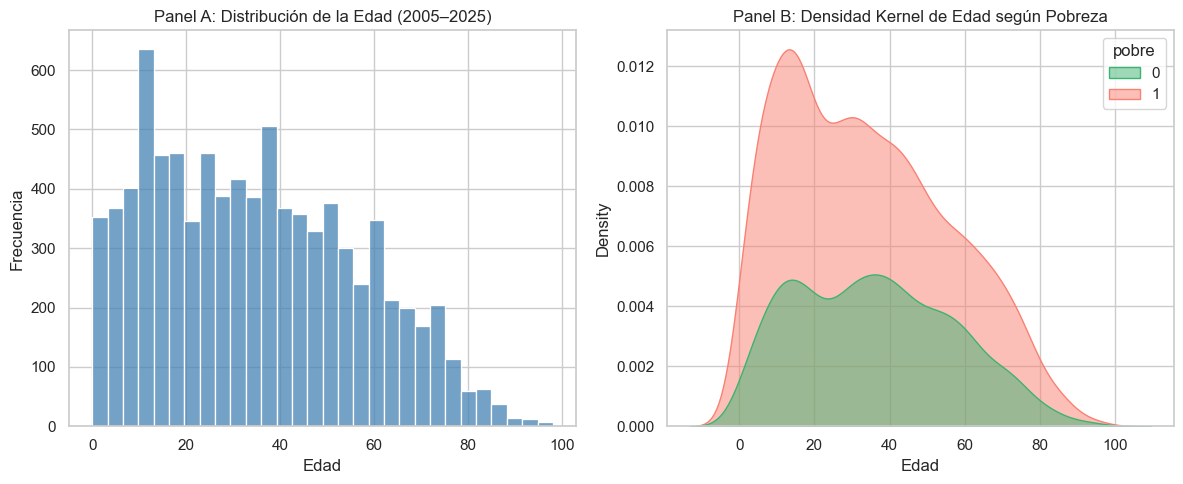

In [4]:
# === 4) Visualización: Edad ===
plt.figure(figsize=(12,5))

# Panel A: Histograma de edad
plt.subplot(1,2,1)
sns.histplot(eph["ch06"], bins=30, color="steelblue", kde=False)
plt.title("Panel A: Distribución de la Edad (2005–2025)")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")

# Panel B: Densidad Kernel por pobreza
plt.subplot(1,2,2)
sns.kdeplot(data=eph, x="ch06", hue="pobre", fill=True,
            palette={0:"mediumseagreen",1:"salmon"}, alpha=0.5)
plt.title("Panel B: Densidad Kernel de Edad según Pobreza")
plt.xlabel("Edad")

plt.tight_layout()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


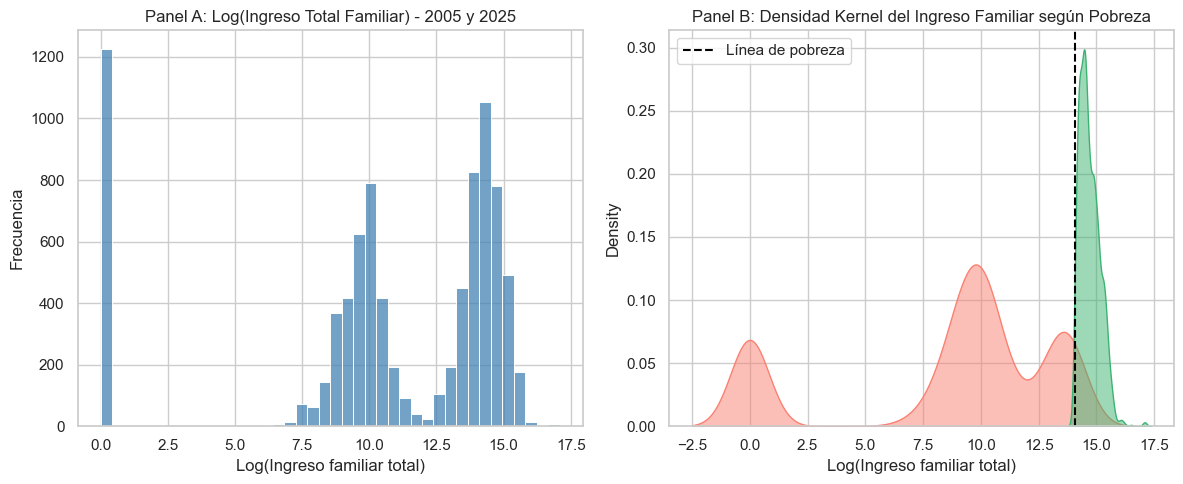

In [5]:
# === 5) Visualización: Ingreso familiar ===
plt.figure(figsize=(12,5))

# Panel A: Histograma
plt.subplot(1,2,1)
sns.histplot(np.log1p(eph["itf_2025"]), bins=40, color="steelblue", kde=False)
plt.title("Panel A: Log(Ingreso Total Familiar) - 2005 y 2025")
plt.xlabel("Log(Ingreso familiar total)")
plt.ylabel("Frecuencia")

# Panel B: Kernel por pobreza
plt.subplot(1,2,2)
sns.kdeplot(data=eph, x=np.log1p(eph["itf_2025"]), hue="pobre", fill=True,
            palette={0:"mediumseagreen",1:"salmon"}, alpha=0.5)
plt.axvline(np.log1p(eph["linea_pobreza"].iloc[0]), color="black", ls="--", lw=1.5, label="Línea de pobreza")
plt.legend()
plt.title("Panel B: Densidad Kernel del Ingreso Familiar según Pobreza")
plt.xlabel("Log(Ingreso familiar total)")

plt.tight_layout()
plt.show()

In [6]:
# === 6) Descriptivos básicos ===
tabla_desc = eph[["ch06","educ","itf_2025","horastrab"]].describe().T
print("Tabla descriptiva general:\n")
print(tabla_desc)

Tabla descriptiva general:

             count       mean          std  min       25%       50%  \
ch06      8,588.00      34.65        21.70 0.00     16.00     33.00   
educ      5,359.00       7.89         4.71 0.00      6.00      9.00   
itf_2025  8,588.00 975,431.49 1,525,597.37 0.00 10,500.00 59,850.00   
horastrab     0.00        NaN          NaN  NaN       NaN       NaN   

                   75%           max  
ch06             51.00         98.00  
educ             12.00         16.00  
itf_2025  1,600,000.00 26,400,000.00  
horastrab          NaN           NaN  


In [7]:
# === 7) Tabla resumen por año ===
tabla_1 = eph.groupby("ano4").agg(
    obs_totales = ("ano4", "count"),
    pobres = ("pobre", "sum"),
    no_pobres = ("pobre", lambda x: (x==0).sum()),
    edad_prom = ("ch06", "mean"),
    educ_prom = ("educ", "mean"),
    ingreso_prom = ("itf_2025", "mean")
).reset_index()

tabla_1["tasa_pobreza_%"] = 100 * tabla_1["pobres"] / tabla_1["obs_totales"]
print(tabla_1)

   ano4  obs_totales  pobres  no_pobres  edad_prom  educ_prom  ingreso_prom  \
0  2005         3229    3229          0      29.69        NaN     21,201.32   
1  2025         5359    2732       2627      37.63       7.89  1,550,391.22   

   tasa_pobreza_%  
0          100.00  
1           50.98  


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


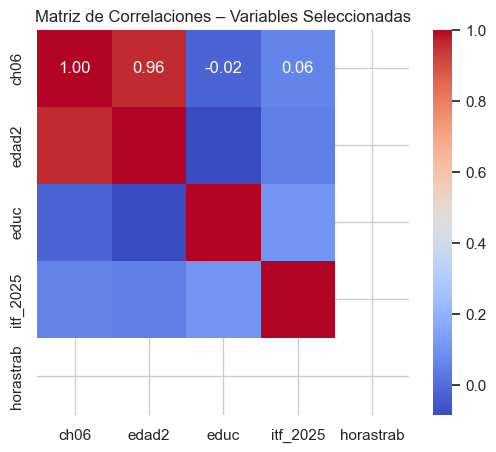

In [8]:
# === 8) Matriz de correlaciones ===
vars_corr = ["ch06","edad2","educ","itf_2025","horastrab"]
corr = eph[vars_corr].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlaciones – Variables Seleccionadas")
plt.show()

Cantidad de filas con datos completos: 5359


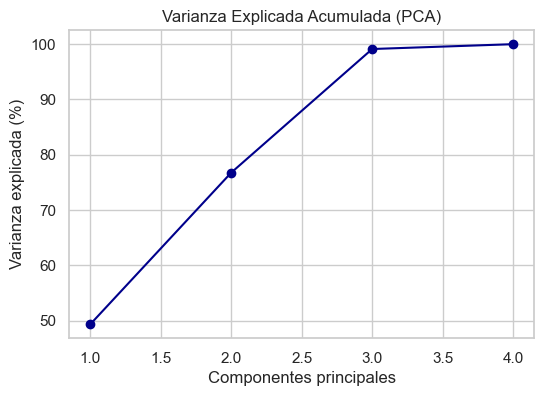

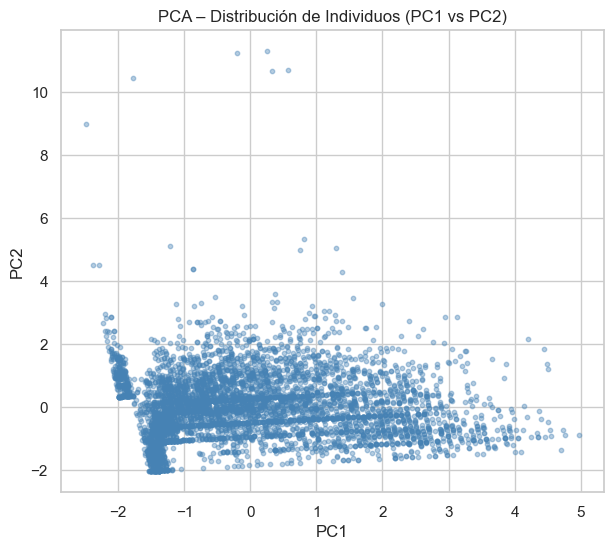

In [9]:
# === 9) PCA (corregido) ===

# Variables sin tantos faltantes
vars_pca = ["ch06","edad2","educ","itf_2025"]

# Verificamos cuántas filas completas hay
print("Cantidad de filas con datos completos:", eph[vars_pca].dropna().shape[0])

# Eliminamos filas con NaN solo en estas columnas
X = eph[vars_pca].dropna()

# Escalamos las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ajustamos PCA
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# Scree Plot
plt.figure(figsize=(6,4))
plt.plot(range(1,5), np.cumsum(pca.explained_variance_ratio_)*100, marker='o', color='darkblue')
plt.title("Varianza Explicada Acumulada (PCA)")
plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada (%)")
plt.grid(True)
plt.show()

# Biplot: PC1 vs PC2
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.4, color='steelblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA – Distribución de Individuos (PC1 vs PC2)")
plt.show()

In [10]:
# === 10) Loadings de PCA (ajustado a 4 variables) ===
loadings = pd.DataFrame(
    pca.components_.T,
    index=vars_pca,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

print("Cargas (loadings) de las variables en los componentes principales:\n")
display(loadings.round(3))

Cargas (loadings) de las variables en los componentes principales:



,PC1,PC2,PC3,PC4
ch06,0.70,0.10,-0.02,-0.70
edad2,0.70,0.05,0.01,0.71
educ,-0.08,0.70,-0.71,0.04
itf_2025,-0.07,0.70,0.71,0.01


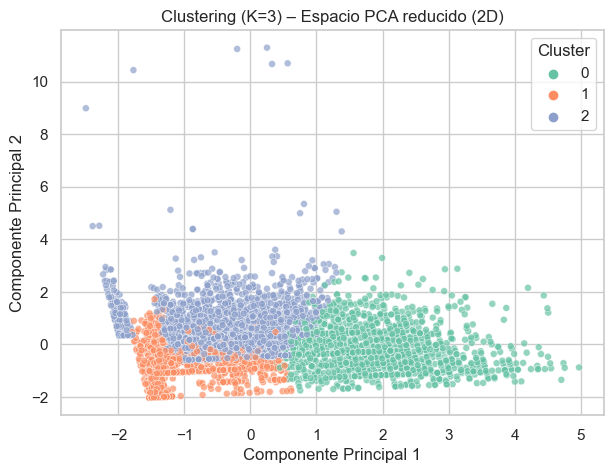

In [11]:
# === 11) K-Means (con las mismas 4 variables del PCA) ===
from sklearn.cluster import KMeans

# Usamos las mismas variables que en el PCA
X = eph[["ch06","edad2","educ","itf_2025"]].dropna()

# Escalamos nuevamente (igual que en el PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ajustamos K-Means para distintos k
kmeans_results = {}
for k in [2, 3, 4]:
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    eph[f"cluster_{k}"] = np.nan
    eph.loc[X.index, f"cluster_{k}"] = labels
    kmeans_results[k] = kmeans.inertia_

# Visualización para k=3 (ejemplo principal)
pca_plot = PCA(n_components=2)
coords = pca_plot.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
sns.scatterplot(x=coords[:,0], y=coords[:,1],
                hue=eph.loc[X.index,"cluster_3"].astype(int),
                palette="Set2", s=25, alpha=0.7)
plt.title("Clustering (K=3) – Espacio PCA reducido (2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.show()

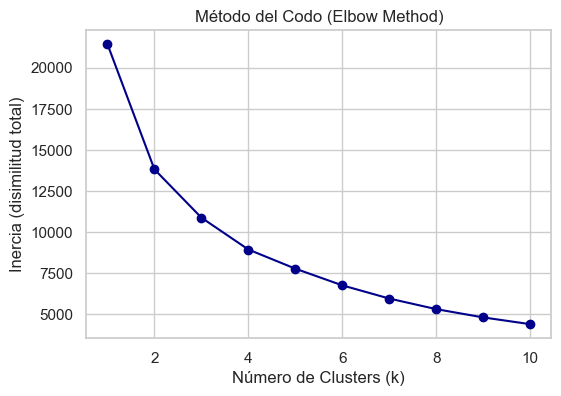

In [12]:
# === 12) Método del Codo ===
ks = range(1, 11)
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker='o', color='darkblue')
plt.title("Método del Codo (Elbow Method)")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia (disimilitud total)")
plt.grid(True)
plt.show()

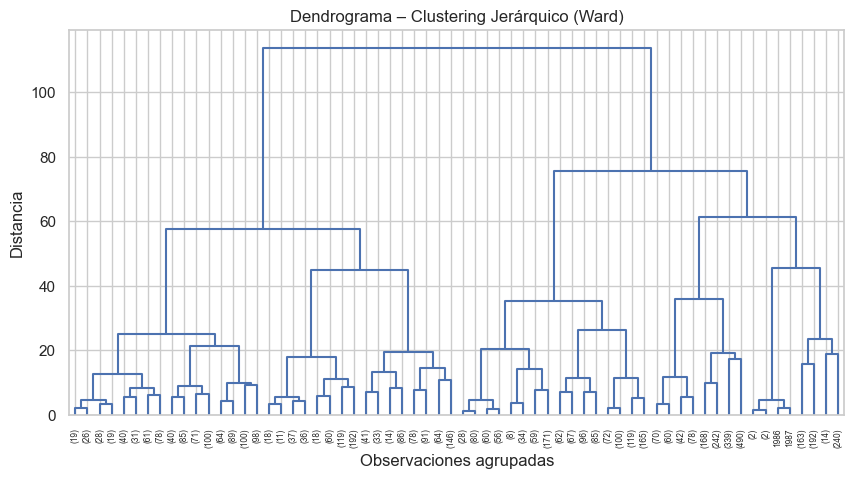

In [13]:
# === 13) Clustering jerárquico ===
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(10,5))
dendrogram(Z, truncate_mode='level', p=5, color_threshold=0)
plt.title("Dendrograma – Clustering Jerárquico (Ward)")
plt.xlabel("Observaciones agrupadas")
plt.ylabel("Distancia")
plt.show()

In [14]:
# === 14) Guardar base con resultados ===
ruta_salida = os.path.join(DATOS, "base_TP2_resultados.csv")
eph.to_csv(ruta_salida, index=False, encoding="utf-8-sig")

print("✅ Resultados guardados en:", ruta_salida)

✅ Resultados guardados en: C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\base_TP2_resultados.csv


In [15]:
# === Exportar notebook a PDF (TP2) ===
!jupyter nbconvert --to pdf "Program_TP2_Grupo4.ipynb" --output-dir "C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2"

[NbConvertApp] Converting notebook Program_TP2_Grupo4.ipynb to pdf
[NbConvertApp] Support files will be in Program_TP2_Grupo4_files\
[NbConvertApp] Making directory .\Program_TP2_Grupo4_files
[NbConvertApp] Writing 57633 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 349481 bytes to C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\Program_TP2_Grupo4.pdf


In [40]:
import os

# Ruta principal
CARPETA_RESULTADOS = r"C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados"

# Crear carpeta si no existe
os.makedirs(CARPETA_RESULTADOS, exist_ok=True)
print("Carpeta de resultados lista en:", CARPETA_RESULTADOS)


Carpeta de resultados lista en: C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados


In [41]:
import pandas as pd
import os

# Crear tabla resumen
tabla_resumen = eph.groupby("ano4").agg({
    "itf_2025": ["mean", "median"],
    "ch06": "mean",
    "educ_num": "mean"
}).round(2)

# Mostrar en notebook
display(tabla_resumen)

# Guardar CSV y Excel en carpeta de resultados
ruta_csv = os.path.join(CARPETA_RESULTADOS, "tabla_resumen_2005_2025.csv")
ruta_xlsx = os.path.join(CARPETA_RESULTADOS, "tabla_resumen_2005_2025.xlsx")

tabla_resumen.to_csv(ruta_csv, encoding="utf-8", index=True)
tabla_resumen.to_excel(ruta_xlsx, merge_cells=False)

print("\n✅ Tabla exportada correctamente en:")
print("CSV:", ruta_csv)
print("XLSX:", ruta_xlsx)


itf_2025               ch06 educ_num
             mean       median  mean     mean
ano4                                         
2005    21,201.32    16,800.00 29.69     0.00
2025 1,550,391.22 1,250,000.00 37.63     2.56


✅ Tabla exportada correctamente en:
CSV: C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados\tabla_resumen_2005_2025.csv
XLSX: C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados\tabla_resumen_2005_2025.xlsx


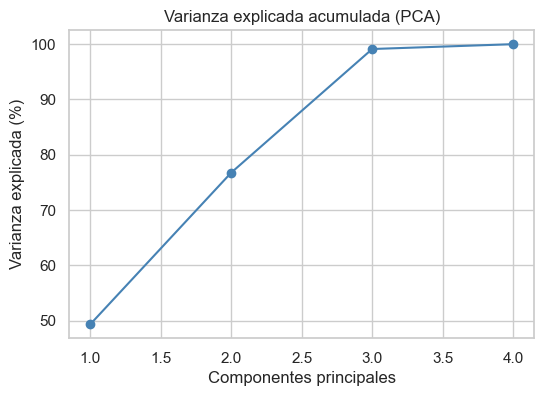

✅ Figura 1 guardada en: C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados\figura_1_scree_pca.png


In [42]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(6,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         np.cumsum(pca.explained_variance_ratio_)*100, marker='o', color='steelblue')
plt.title("Varianza explicada acumulada (PCA)")
plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada (%)")
plt.grid(True)

ruta_fig1 = os.path.join(CARPETA_RESULTADOS, "figura_1_scree_pca.png")
plt.savefig(ruta_fig1, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Figura 1 guardada en:", ruta_fig1)

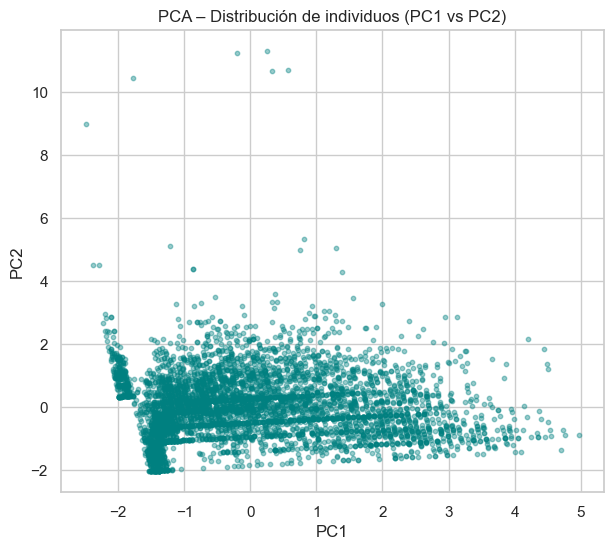

✅ Figura 2 guardada en: C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados\figura_2_biplot_pca.png


In [43]:
fig = plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.4, color='teal')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA – Distribución de individuos (PC1 vs PC2)")

ruta_fig2 = os.path.join(CARPETA_RESULTADOS, "figura_2_biplot_pca.png")
plt.savefig(ruta_fig2, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Figura 2 guardada en:", ruta_fig2)

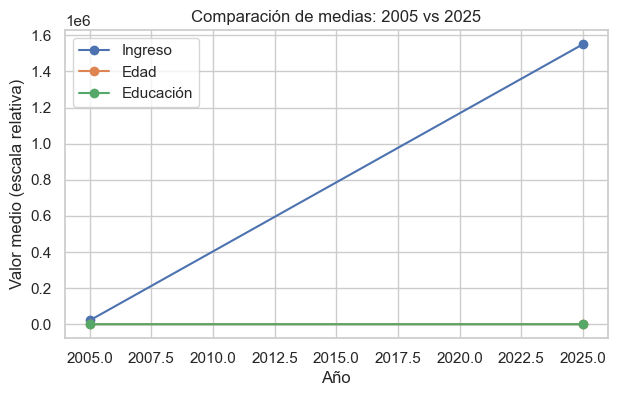

✅ Figura 3 guardada en: C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados\figura_3_comparacion_medias.png


In [44]:
t2 = tabla_resumen.copy()
t2.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in t2.columns]
t2 = t2.reset_index()

plt.figure(figsize=(7,4))
for col, label in zip(["itf_2025_mean","ch06_mean","educ_num_mean"],
                      ["Ingreso", "Edad", "Educación"]):
    plt.plot(t2["ano4"], t2[col], marker="o", label=label)
plt.title("Comparación de medias: 2005 vs 2025")
plt.xlabel("Año")
plt.ylabel("Valor medio (escala relativa)")
plt.legend()
plt.grid(True)

ruta_fig3 = os.path.join(CARPETA_RESULTADOS, "figura_3_comparacion_medias.png")
plt.savefig(ruta_fig3, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Figura 3 guardada en:", ruta_fig3)

In [45]:
import os
archivos = [x for x in os.listdir(CARPETA_RESULTADOS) if x.startswith(("tabla_", "figura_"))]
print("Archivos en carpeta de resultados:\n", archivos)


Archivos en carpeta de resultados:
 ['figura_1_scree_pca.png', 'figura_2_biplot_pca.png', 'figura_3_comparacion_medias.png', 'tabla_resumen_2005_2025.csv', 'tabla_resumen_2005_2025.xlsx']


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


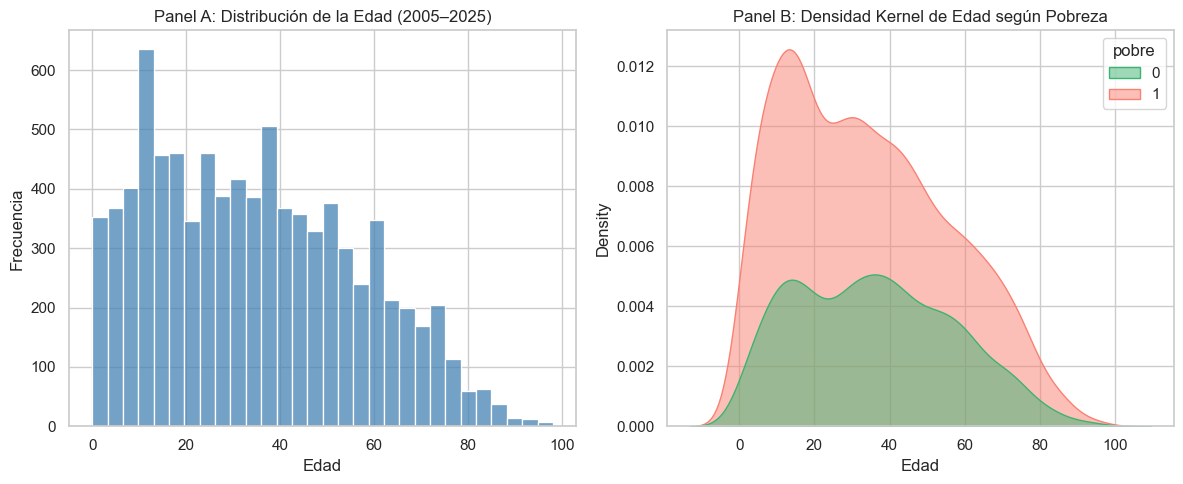

✅ Figura 4 guardada en: C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados\figura_4_distribucion_edad.png


In [46]:
# ============================================================
# === 4) Visualización: Edad (Histogramas y Densidades) ===
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
import os

# Crear figura
plt.figure(figsize=(12,5))

# Panel A: Histograma de edad
plt.subplot(1,2,1)
sns.histplot(eph["ch06"], bins=30, color="steelblue", kde=False)
plt.title("Panel A: Distribución de la Edad (2005–2025)")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")

# Panel B: Densidad Kernel por pobreza
plt.subplot(1,2,2)
sns.kdeplot(data=eph, x="ch06", hue="pobre", fill=True,
            palette={0:"mediumseagreen", 1:"salmon"}, alpha=0.5)
plt.title("Panel B: Densidad Kernel de Edad según Pobreza")
plt.xlabel("Edad")

plt.tight_layout()

# === Guardar en carpeta de resultados ===
ruta_fig_edad = os.path.join(
    r"C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados",
    "figura_4_distribucion_edad.png"
)

plt.savefig(ruta_fig_edad, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Figura 4 guardada en:", ruta_fig_edad)

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


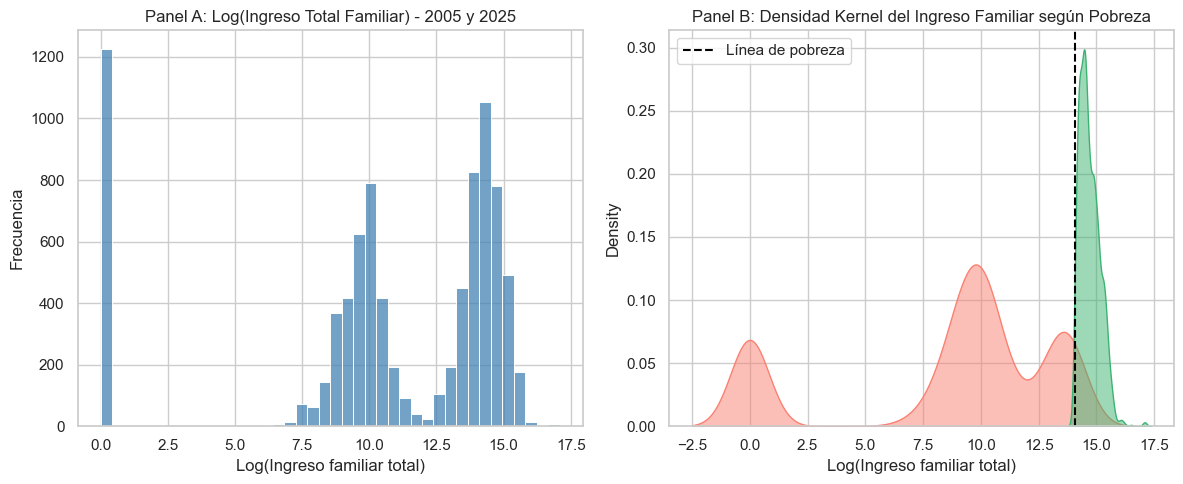

✅ Figura 5 guardada en: C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados\figura_5_distribucion_ingreso.png


In [47]:
# ============================================================
# === 5) Visualización: Ingreso familiar (Hist + Densidad) ===
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Crear figura
plt.figure(figsize=(12,5))

# Panel A: Histograma del log(Ingreso familiar total)
plt.subplot(1,2,1)
sns.histplot(np.log1p(eph["itf_2025"]), bins=40, color="steelblue", kde=False)
plt.title("Panel A: Log(Ingreso Total Familiar) - 2005 y 2025")
plt.xlabel("Log(Ingreso familiar total)")
plt.ylabel("Frecuencia")

# Panel B: Densidad Kernel por pobreza
plt.subplot(1,2,2)
sns.kdeplot(data=eph, x=np.log1p(eph["itf_2025"]), hue="pobre", fill=True,
            palette={0:"mediumseagreen", 1:"salmon"}, alpha=0.5)

# Línea vertical = línea de pobreza
if "linea_pobreza" in eph.columns:
    plt.axvline(np.log1p(eph["linea_pobreza"].iloc[0]), color="black", ls="--", lw=1.5, label="Línea de pobreza")

plt.legend()
plt.title("Panel B: Densidad Kernel del Ingreso Familiar según Pobreza")
plt.xlabel("Log(Ingreso familiar total)")

plt.tight_layout()

# === Guardar en carpeta de resultados ===
ruta_fig_ingreso = os.path.join(
    r"C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados",
    "figura_5_distribucion_ingreso.png"
)
plt.savefig(ruta_fig_ingreso, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Figura 5 guardada en:", ruta_fig_ingreso)

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


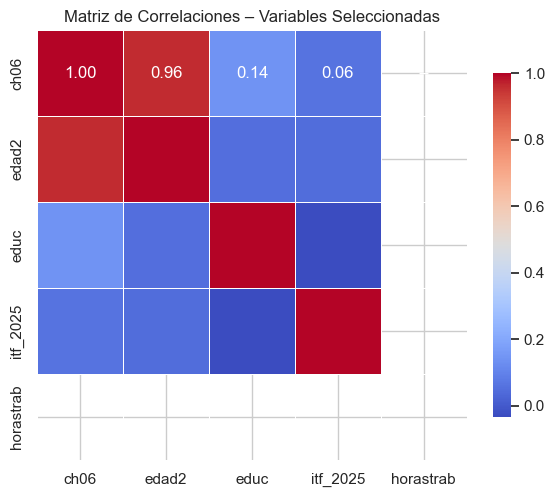

✅ Figura 6 guardada en: C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados\figura_6_matriz_correlaciones.png


In [48]:
# ============================================================
# === 8) Matriz de correlaciones – Variables seleccionadas ===
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
import os

# Selección de variables
vars_corr = ["ch06", "edad2", "educ", "itf_2025", "horastrab"]

# Calcular matriz de correlaciones
corr = eph[vars_corr].corr()

# Crear figura
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True,
            cbar_kws={"shrink": .8}, linewidths=.5)
plt.title("Matriz de Correlaciones – Variables Seleccionadas")
plt.tight_layout()

# === Guardar en carpeta de resultados ===
ruta_fig_corr = os.path.join(
    r"C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados",
    "figura_6_matriz_correlaciones.png"
)
plt.savefig(ruta_fig_corr, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Figura 6 guardada en:", ruta_fig_corr)

✅ Filas completas utilizadas para PCA: 5359


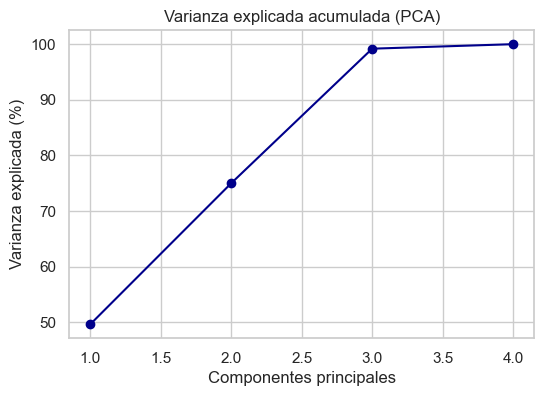

✅ Figura 7 guardada en: C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados\figura_7_scree_plot_pca.png


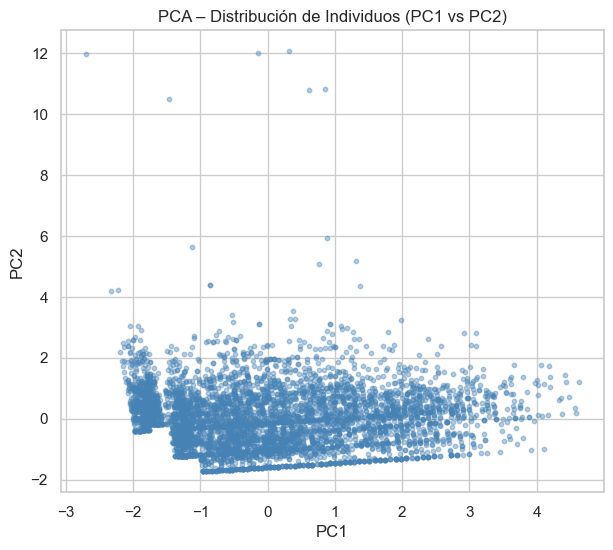

✅ Figura 8 guardada en: C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados\figura_8_biplot_pca.png


In [51]:
# ============================================================
# === 9) PCA (versión robusta, sin NaN) ===
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

# Variables seleccionadas para PCA
vars_pca = ["ch06", "edad2", "educ", "itf_2025"]

# Filtramos solo filas numéricas válidas (sin NaN o strings)
X = eph[vars_pca].apply(pd.to_numeric, errors="coerce").dropna()

print("✅ Filas completas utilizadas para PCA:", X.shape[0])

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA con 4 componentes
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# ============================================================
# === Figura 7: Scree Plot – Varianza explicada acumulada ===
# ============================================================

plt.figure(figsize=(6,4))
plt.plot(range(1, 5), np.cumsum(pca.explained_variance_ratio_) * 100,
         marker='o', color='darkblue')
plt.title("Varianza explicada acumulada (PCA)")
plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada (%)")
plt.grid(True)

ruta_fig7 = os.path.join(
    r"C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados",
    "figura_7_scree_plot_pca.png"
)
plt.savefig(ruta_fig7, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Figura 7 guardada en:", ruta_fig7)

# ============================================================
# === Figura 8: Biplot – PC1 vs PC2 ===
# ============================================================

plt.figure(figsize=(7,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.4, color='steelblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA – Distribución de Individuos (PC1 vs PC2)")
plt.grid(True)

ruta_fig8 = os.path.join(
    r"C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados",
    "figura_8_biplot_pca.png"
)
plt.savefig(ruta_fig8, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Figura 8 guardada en:", ruta_fig8)

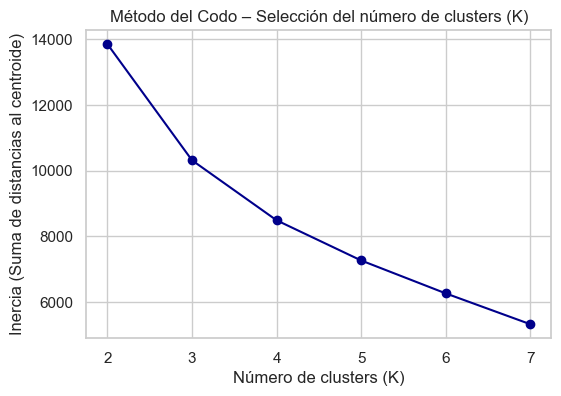

✅ Figura 9 guardada en: C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados\figura_9_elbow_kmeans.png


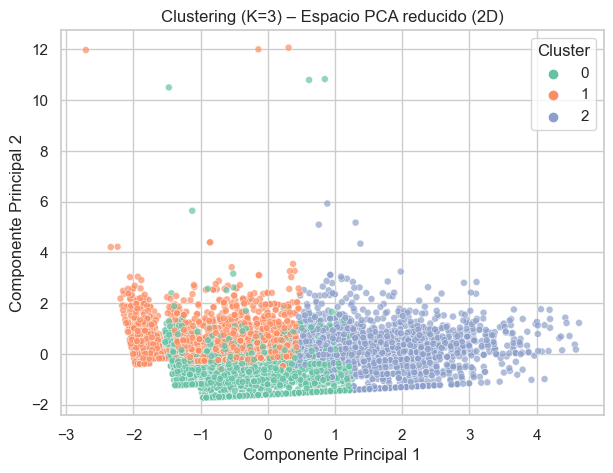

✅ Figura 10 guardada en: C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados\figura_10_kmeans_clusters.png


In [52]:
# ============================================================
# === 11) K-Means (usando las mismas 4 variables del PCA) ===
# ============================================================

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Selección de variables y limpieza
vars_cluster = ["ch06", "edad2", "educ", "itf_2025"]
X = eph[vars_cluster].apply(pd.to_numeric, errors="coerce").dropna()

# Escalado de variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================================================
# === A) Método del Codo (Elbow Plot) ===
# ============================================================

inertia = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o', color='darkblue')
plt.title("Método del Codo – Selección del número de clusters (K)")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia (Suma de distancias al centroide)")
plt.grid(True)

ruta_fig9 = os.path.join(
    r"C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados",
    "figura_9_elbow_kmeans.png"
)
plt.savefig(ruta_fig9, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Figura 9 guardada en:", ruta_fig9)

# ============================================================
# === B) K-Means con K=3 (análisis principal) ===
# ============================================================

kmeans = KMeans(n_clusters=3, n_init=20, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Reducimos a 2 componentes para graficar
pca_2d = PCA(n_components=2)
coords = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
sns.scatterplot(x=coords[:,0], y=coords[:,1],
                hue=labels, palette="Set2", s=25, alpha=0.7)
plt.title("Clustering (K=3) – Espacio PCA reducido (2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.grid(True)

ruta_fig10 = os.path.join(
    r"C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados",
    "figura_10_kmeans_clusters.png"
)
plt.savefig(ruta_fig10, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Figura 10 guardada en:", ruta_fig10)

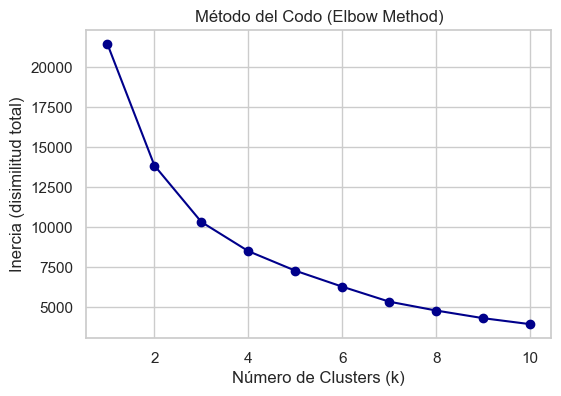

✅ Figura 11 guardada en: C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados\figura_11_elbow_method.png


In [53]:
# ============================================================
# === 12) Método del Codo (Elbow Method) ===
# ============================================================

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import os

# Asegúrate de que X_scaled ya esté definido (desde el bloque anterior del K-Means)
# Si no, puedes volver a crearlo:
# X = eph[["ch06","edad2","educ","itf_2025"]].apply(pd.to_numeric, errors="coerce").dropna()
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

ks = range(1, 11)
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker='o', color='darkblue')
plt.title("Método del Codo (Elbow Method)")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia (disimilitud total)")
plt.grid(True)

# === Guardar en carpeta de resultados ===
ruta_fig_elbow = os.path.join(
    r"C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados",
    "figura_11_elbow_method.png"
)
plt.savefig(ruta_fig_elbow, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Figura 11 guardada en:", ruta_fig_elbow)

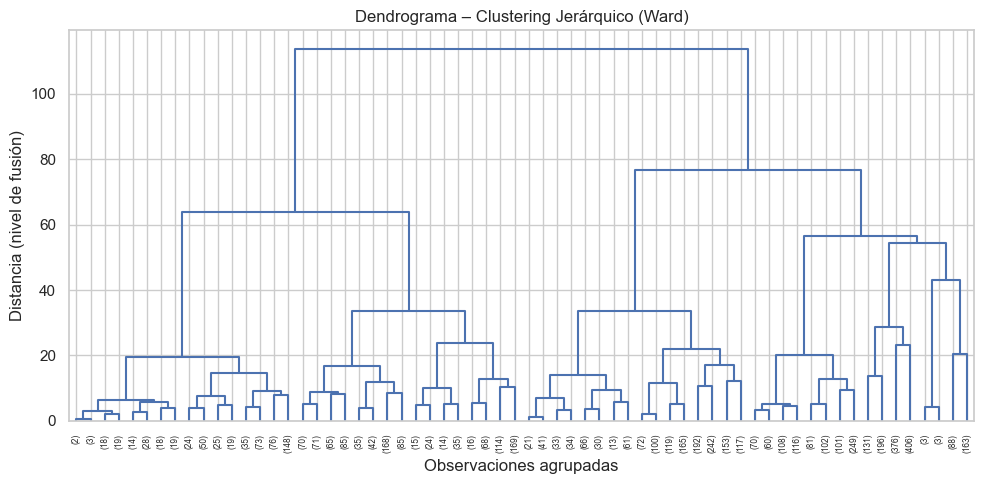

✅ Figura 12 guardada en: C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados\figura_12_dendrograma_jerarquico.png


In [54]:
# ============================================================
# === 13) Clustering jerárquico (Ward) ===
# ============================================================

from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import os

# Asegúrate de tener X_scaled definido desde el bloque anterior
# (X_scaled = StandardScaler().fit_transform(X))

# Aplicamos el método de Ward
Z = linkage(X_scaled, method='ward')

# Crear figura
plt.figure(figsize=(10,5))
dendrogram(Z, truncate_mode='level', p=5, color_threshold=0)
plt.title("Dendrograma – Clustering Jerárquico (Ward)")
plt.xlabel("Observaciones agrupadas")
plt.ylabel("Distancia (nivel de fusión)")
plt.tight_layout()

# === Guardar en carpeta de resultados ===
ruta_fig_dendro = os.path.join(
    r"C:\Users\econz\OneDrive\Documentos\Lecturas libros\Cursos UBA\Programación\Grupo4_UBA_2025\TP2\resultados",
    "figura_12_dendrograma_jerarquico.png"
)
plt.savefig(ruta_fig_dendro, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Figura 12 guardada en:", ruta_fig_dendro)